# Lab 2: Convolutional Neural Network 
This notebook has been prepared by Hsiu-Wen (Kelly) Chang from MINES ParisTech for the class of HPC-AI 2025


## Goal
In this lab, we move to a more complicated classification task with with CNN artecture to improve the performance. 

In [7]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cuda:0


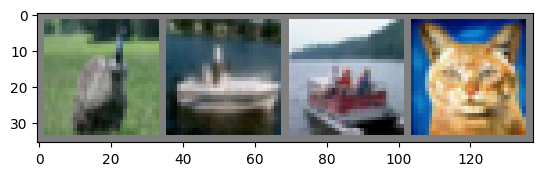

bird  ship  ship  cat  


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Convolutions

Compare to the result in lab MLP, tt turns out that there is a very efficient way to makes advantage of the structure of the information encoded within an image---it is assumed that pixels that are spatially *closer* together will "cooperate" on forming a particular feature of interest much more than ones on opposite corners of the image. Also, if a particular (smaller) feature is found to be of great importance when defining an image's label, it will be equally important if this feature was found anywhere within the image, regardless of location.

Enter the **convolution** operator. Given a two-dimensional image, $\bf I$, and a small matrix, $\bf K$ of size $h \times w$, (known as a *convolution kernel*), which we assume encodes a way of extracting an interesting image feature, we compute the convolved image, ${\bf I} * {\bf K}$, by overlaying the kernel on top of the image in all possible ways, and recording the sum of elementwise products between the image and the kernel:

$$({\bf I} * {\bf K})_{xy} = \sum_{i=1}^h \sum_{j=1}^w {{\bf K}_{ij} \cdot {\bf I}_{x + i - 1, y + j - 1}}$$

(in fact, the exact definition would require us to flip the kernel matrix first, but for the purposes of machine learning it is irrelevant whether this is done)

The images below show a diagrammatical overview of the above formula and the result of applying convolution (with two separate kernels) over an image, to act as an edge detector:

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/convolve.png)
![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/lena.jpg)

### Convolutional layers and Pooling layers

The convolution operator forms the fundamental basis of the **convolutional** layer of a CNN. The layer is completely specified by a certain number of kernels, $\bf \vec{K}$ (along with additive biases, $\vec{b}$, per each kernel), and it operates by computing the convolution of the output images of a previous layer with each of those kernels, afterwards adding the biases (one per each output image). Finally, an activation function, $\sigma$, may be applied to all of the pixels of the output images. Typically, the input to a convolutional layer will have $d$ *channels* (e.g. red/green/blue in the input layer), in which case the kernels are extended to have this number of channels as well, making the final formula of a single output image channel of a convolutional layer (for a kernel ${\bf K}$ and bias $b$) as follows:

$$\mathrm{conv}({\bf I}, {\bf K})_{xy} = \sigma\left(b + \sum_{i=1}^h \sum_{j=1}^w \sum_{k=1}^d {{\bf K}_{ijk} \cdot {\bf I}_{x + i - 1, y + j - 1, k}}\right)$$

Note that, since all we're doing here is addition and scaling of the input pixels, the kernels may be learned from a given training dataset via *gradient descent*, exactly as the weights of an MLP. In fact, an MLP is perfectly capable of replicating a convolutional layer, but it would require a lot more training time (and data) to learn to approximate that mode of operation.

Finally, let's just note that a convolutional operator is in no way restricted to two-dimensionally structured data: in fact, most machine learning frameworks will provide you with out-of-the-box layers for 1D and 3D convolutions as well!

It is important to note that, while a convolutional layer significantly decreases the number of *parameters* compared to a fully connected (FC) layer, it introduces more **hyperparameters**---parameters whose values need to be chosen *before* training starts.

Namely, the hyperparameters to choose within a single convolutional layer are:
- *depth*: how many different kernels (and biases) will be convolved with the output of the previous layer;
- *height* and *width* of each kernel;
- *stride*: by how much we shift the kernel in each step to compute the next pixel in the result. This specifies the overlap between individual output pixels, and typically it is set to $1$, corresponding to the formula given before. Note that larger strides result in smaller output sizes.
- *padding*: note that convolution by any kernel larger than $1\times 1$ will *decrease* the output image size---it is often desirable to keep sizes the same, in which case the image is sufficiently padded with zeroes at the edges. This is often called *"same"* padding, as opposed to *"valid"* (no) padding. It is possible to add arbitrary levels of padding, but typically the padding of choice will be either same or valid.

As already hinted, convolutions are not typically meant to be the sole operation in a CNN (although there have been promising recent developments on [all-convolutional networks](https://arxiv.org/pdf/1412.6806v3.pdf)); but rather to extract useful features of an image prior to downsampling it sufficiently to be manageable by an MLP.

A very popular approach to downsampling is a *pooling* layer, which consumes small and (usually) disjoint chunks of the image (typically $2\times 2$) and aggregates them into a single value. There are several possible schemes for the aggregation---the most popular being **max-pooling**, where the maximum pixel value within each chunk is taken. A diagrammatical illustration of $2\times 2$ max-pooling is given below.

In [9]:
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

 
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Now we can start training while we print the validation test to track the training performance

(Note that we always call ``model.train()`` before training, and ``model.eval()``
before inference, because these are used by layers such as ``nn.BatchNorm2d``
and ``nn.Dropout`` to ensure appropriate behaviour for these different phases.)

In [ ]:
epochs = 2

trainingEpoch_loss = []
validationEpoch_loss = []

for epoch in range(epochs):
    
    # Make sure gradient tracking is on, and do a pass over the data
    net.train(True)
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        trainingEpoch_loss.append(loss.item())
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    net.eval()

    # Validation loss
    validation_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device))
            loss = criterion(outputs, labels.to(device))
            validation_loss += loss.item()
    validationEpoch_loss.append(validation_loss / len(testloader))
    print(f'Epoch {epoch +1} validation loss: {validation_loss / len(testloader):.3f}')

print('Finished Training')

[1,  2000] loss: 0.883
[1,  4000] loss: 0.895
[1,  6000] loss: 0.924
[1,  8000] loss: 0.925
[1, 10000] loss: 0.942
[1, 12000] loss: 0.938
Epoch 1 validation loss: 1.249
[2,  2000] loss: 0.844
[2,  4000] loss: 0.861
[2,  6000] loss: 0.877
[2,  8000] loss: 0.901
[2, 10000] loss: 0.903
[2, 12000] loss: 0.909
Epoch 2 validation loss: 1.188
Finished Training


Save your model

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Test the network on the test data

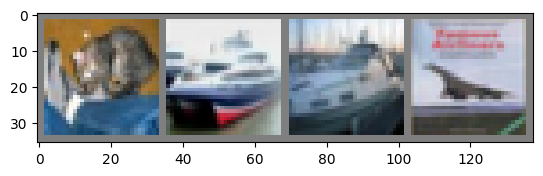

GroundTruth:  cat   ship  ship  plane


In [15]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Now let see what is the performance on all the test data


In [18]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 59 %


Let's see how this CNN predicts all the class

In [17]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 60.1 %
Accuracy for class: car   is 75.6 %
Accuracy for class: bird  is 52.9 %
Accuracy for class: cat   is 50.3 %
Accuracy for class: deer  is 50.7 %
Accuracy for class: dog   is 37.9 %
Accuracy for class: frog  is 48.7 %
Accuracy for class: horse is 71.8 %
Accuracy for class: ship  is 84.8 %
Accuracy for class: truck is 66.9 %


$\textbf{Practice 1} $: try to add hidden layer and train this CNN to have better results

### Overfitting, regularisation and dropout

Overfitting corresponds to adapting our model to the training set to such extremes that its generalisation potential (performance on samples outside of the training set) is *severely* limited. In other words, our model might have learned the training set (along with any noise present within it) perfectly, but it has failed to capture the underlying process that generated it. To illustrate, consider a problem of fitting a linear line, with white additive noise applied to the data points

coeffs for higher polynomial (highest->lowest): [ 1.41052647e-04 -1.45944626e-03 -1.41002704e-03  8.26307002e-02
  6.82699658e-01  3.84391300e-01]
coeffs for lower polynomial (highest->lowest): [0.99165582 0.11316157]
training loss with higher polynomial: 1.232595164407831e-30
training loss with lower polynomial: 0.0016310463981782897
test loss with higher polynomial: 0.016465992810365242
test loss with lower polynomial: 0.014328676916971199


/tmp/ipykernel_2332338/1000331358.py:8: RankWarning: Polyfit may be poorly conditioned
  coeffs_h = np.polyfit(x, y, deg=5)  # higher degree polynomial


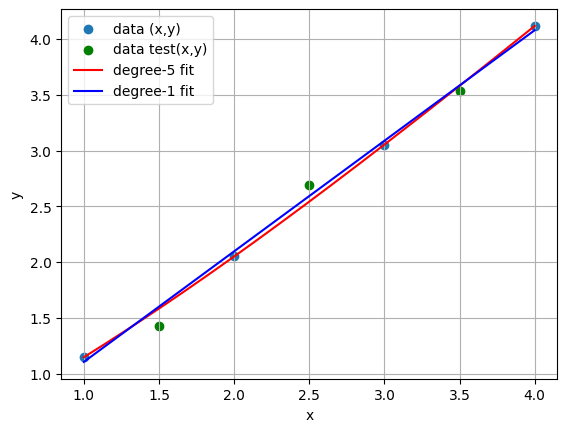

In [3]:
# This example show you the overfitting and generalization issue using polynomial fitting
x = np.array([1, 2, 3, 4])
y = x +np.random.randn(4) * 0.1 # true function is y = x with noise 0.1
x_test = np.array([1.5, 2.5, 3.5])
y_test = x_test+np.random.randn(3) * 0.1

# fit polynomial (will exactly interpolate 4 points)
coeffs_h = np.polyfit(x, y, deg=5)  # higher degree polynomial
coeffs_l = np.polyfit(x, y, deg=1)  # true degree is 1
print('coeffs for higher polynomial (highest->lowest):', coeffs_h)
print('coeffs for lower polynomial (highest->lowest):', coeffs_l)

# build polynomial and evaluate
ph = np.poly1d(coeffs_h)
pl = np.poly1d(coeffs_l)
x_fit = np.linspace(x.min(), x.max(), 200)
y_fit = ph(x_fit)
y_fit_l = pl(x_fit)
y_pred = ph(x)
y_pred_l = pl(x)
y_test_pred = ph(x_test)
y_test_pred_l = pl(x_test)
print('training loss with higher polynomial:', np.mean((y - y_pred)**2))
print('training loss with lower polynomial:', np.mean((y - y_pred_l)**2))
print('test loss with higher polynomial:', np.mean((y_test - y_test_pred)**2))
print('test loss with lower polynomial:', np.mean((y_test - y_test_pred_l)**2))

# plot data and fitted polynomial
plt.scatter(x, y, color='C0', label='data (x,y)')
plt.scatter(x_test, y_test, color='g', label='data test(x,y)')
plt.plot(x_fit, y_fit, 'r-', label='degree-5 fit')
plt.plot(x_fit, y_fit_l, 'b-', label='degree-1 fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

Here we have a training set (denoted by blue circles) derived from the linear function, along with some noise. If we fit a degree-5 polynomial to this data, we get a much lower traiing loss compare to degree-1. Such a fit would *perfectly* describe the training data. However, in this case, the additional parameters of the model cause catastrophic results: to cope with the inherent noise of the data, anywhere except in the closest vicinity of the training points, our fit is completely off.

Deep convolutional neural networks have a large number of parameters, especially in the fully connected layers. Overfitting might often manifest in the following form: if we don't have sufficiently many training examples, a small group of neurons might become responsible for doing most of the processing and other neurons becoming redundant; or in the other extreme, some neurons might actually become detrimental to performance, with several other neurons of their layer ending up doing nothing else but correcting for their errors.

To help our models generalise better in these circumstances, we introduce techniques of *regularisation*: rather than reducing the number of parameters (change the architecture of CNN), we impose *constraints* on the model parameters during training to keep them from learning the noise in the training data. The particular method introduce here is **dropout**. Namely, dropout with parameter $p$ will, within a single training iteration, go through all neurons in a particular layer and, with probability $p$, *completely eliminate them from the network throughout the iteration*. This has the effect of forcing the neural network to cope with *failures*, and not to rely on existence of a particular neuron (or set of neurons)---relying more on a *consensus* of several neurons within a layer. This is a very simple technique that works quite well already for combatting overfitting on its own, without introducing further regularisers.

In [21]:
# add dropout layers to the model to reduce overfitting

class NetDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(p=0.5)  # dropout layer with 50% probability

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # apply dropout after first fully connected layer
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # apply dropout after second fully connected layer
        x = self.fc3(x)
        return x


[1,  2000] loss: 2.239
[1,  4000] loss: 2.012
[1,  6000] loss: 1.880
[1,  8000] loss: 1.794
[1, 10000] loss: 1.745
[1, 12000] loss: 1.701
Epoch 1 validation loss: 7.839
[2,  2000] loss: 1.656
[2,  4000] loss: 1.622
[2,  6000] loss: 1.590
[2,  8000] loss: 1.571
[2, 10000] loss: 1.551
[2, 12000] loss: 1.545
Epoch 2 validation loss: 6.924
Finished Training


Text(0, 0.5, 'Loss')

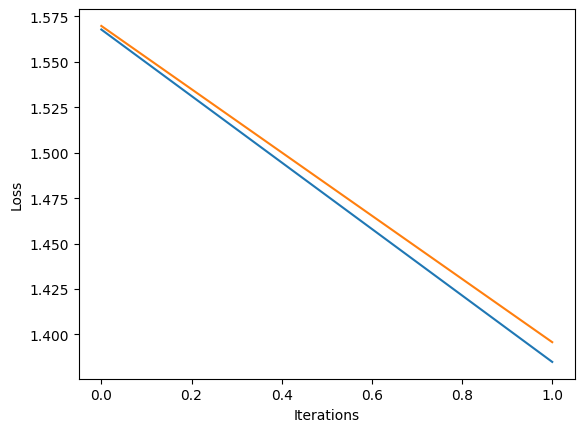

In [ ]:
net = NetDropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 
trainingEpoch_loss = []
validationEpoch_loss = []
for epoch in range(epochs):
    
    # Make sure gradient tracking is on, and do a pass over the data
    net.train(True)
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] training loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    net.eval()

    # Validation loss
    with torch.no_grad():
        validation_loss = 0.0
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device))
            loss = criterion(outputs, labels.to(device))
            validation_loss += loss.item()

        validationEpoch_loss.append(validation_loss / len(testloader))

        validation_loss = 0.0
        for data in trainloader:
            images, labels = data
            outputs = net(images.to(device))
            loss = criterion(outputs, labels.to(device))
            validation_loss += loss.item()
        trainingEpoch_loss.append(validation_loss / len(trainloader))
        
    
    print(f'Epoch {epoch +1} validation loss: {validation_loss / len(testloader):.3f}')

print('Finished Training')

plt.plot(trainingEpoch_loss, label='Training Loss')
plt.plot(validationEpoch_loss, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()